In [1]:
# import packages
import glob
from pathlib import Path
import os
import numpy as np
from datetime import datetime
from datetime import timedelta
import pandas as pd
import calendar
import geopandas as gpd
import cartopy
import matplotlib.pyplot as plt
import math
from pathos.threading import ThreadPool as Pool
from scipy.optimize import least_squares
import sklearn
from sklearn.linear_model import LinearRegression
from scipy.stats import gaussian_kde
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
import random
from scipy.optimize import minimize

In [2]:
# import python functions
from f_snow_module import *
from f_sr_calculation import *

In [3]:
work_dir=Path('/scratch/fransjevanoors/global_sr')
#work_dir=Path('/tudelft.net/staff-umbrella/LSM root zone/global_sr')
data_dir=Path(f'{work_dir}/data')
out_dir = Path(f"{work_dir}/output")

print(work_dir)
print(out_dir)
print(data_dir)


/scratch/fransjevanoors/global_sr
/scratch/fransjevanoors/global_sr/output
/scratch/fransjevanoors/global_sr/data


### 1. Select catchments with snow

In [ ]:
# select catchments with temperature <0 AND precipitation>1, because if no p there is no snow possible
catch_id_list = np.genfromtxt(f'{work_dir}/output/gsim_aus_catch_id_list_lo_sel.txt',dtype='str')[:]
snow_catch=[]
for catch_id in catch_id_list:
    a = pd.read_csv(f'{work_dir}/output/forcing_timeseries/processed/daily/{catch_id}_1981_2010.csv',index_col=0)
    t = a[(a.tas<0)&(a.p>1)]
    if (len(t))>0:
        if (len(t)>0.05*len(a)):
            snow_catch.append(catch_id)
np.savetxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',snow_catch,fmt='%s')

In [4]:
snow_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')[:]
snow_id_list

array(['ar_0000023', 'ar_0000024', 'ar_0000025', ..., 'us_0008723',
       'us_0008726', 'us_0008766'], dtype='<U10')

### 2. get timeseries of liquid precipitation

In [ ]:
catch_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')[0:3]

# run in parallel
# make lists for parallel computation
catch_list = catch_id_list
work_dir_list = [work_dir] * len(catch_list)
run_function_parallel_snow(catch_list, work_dir_list)

In [5]:
len(snow_id_list)

2811

In [8]:
catch_id_list = np.genfromtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')


In [4]:
# check catchments that are not processed yet
catch_id_list_lo_done = []
for filepath in glob.iglob(f'{out_dir}/snow/timeseries/*'):
    f = os.path.split(filepath)[1] # remove full path
    f = f[:-4] # remove .csv extension
    catch_id_list_lo_done.append(f)

dif_list=list(set(catch_id_list)-set(catch_id_list_lo_done))
# dif_list

NameError: name 'catch_id_list' is not defined

## Run sr calculation with and without snow

In [70]:
## 2
def run_sd_calculation(catch_id, pep_dir, q_dir, out_dir,snow_id_list, irri_id_list,snow_dir,work_dir):
    """
    run calculation of storage deficits (1)
    
    catch_id:    str, catchment id
    pep_dir:     str, dir, directory of P and Ep timeseries
    q_dir:       str, dir, directory of Q timeseries
    out_dir:     str, dir, output directory
    
    returns: out:sd timeseries, stores out dataframe (Sd calculation) as csv
    """
    
    if catch_id in snow_id_list:
        s = 1 # snow is yes
        f_pep = glob.glob(f'{snow_dir}/{catch_id}*.csv')

    else:
        s = 0 # snow is no
        # get P Ep and Q files for catch id
        f_pep = glob.glob(f'{pep_dir}/{catch_id}*.csv')

    # read q df
    f_q = glob.glob(f'{q_dir}/{catch_id}*.csv')

    # read files as dataframes
    q_ts = pd.read_csv(f_q[0],index_col=0)
    q_ts.index = pd.to_datetime(q_ts.index)
    pep_ts = pd.read_csv(f_pep[0],index_col=0)
    pep_ts.index = pd.to_datetime(pep_ts.index)

    if (s==1): #snow
        # convert to monthly dataframes
        df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep','ps','pm','pl'])
        df_monthly[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']].groupby(pd.Grouper(freq="M")).sum()

        # calculate start hydroyear -> month after on average the wettest month
        df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
        df_monthly_mean['liq'] = df_monthly_mean['pm'] + df_monthly_mean['pl']
        wettest_month = (df_monthly_mean['liq']-df_monthly_mean['ep']).idxmax()
        hydro_year_start_month = wettest_month+1
        if hydro_year_start_month==13:
            hydro_year_start_month=1

    else: # no snow
        # convert to monthly dataframes
        df_monthly = pd.DataFrame(index=pd.date_range(pep_ts.index[0],pep_ts.index[-1],freq='M'), columns=['p','ep'])
        df_monthly[['p','ep']] = pep_ts[['p','ep']].groupby(pd.Grouper(freq="M")).sum()

        # calculate start hydroyear -> month after on average the wettest month
        df_monthly_mean = df_monthly.groupby([df_monthly.index.month]).mean()
        wettest_month = (df_monthly_mean['p']-df_monthly_mean['ep']).idxmax()
        hydro_year_start_month = wettest_month+1
        if hydro_year_start_month==13:
            hydro_year_start_month=1

    # find the start and end date for the sr calculation based on P, Ep, Q timeseries and hydroyear
    p_ep_start_year = pep_ts.index.year[0]
    q_start_year = int(q_ts.index[0].year)
    p_ep_end_year = pep_ts.index.year[-1]
    q_end_year = int(q_ts.index[-1].year)

    # test if timeseries have overlap -> if not don't continue the sd calculation
    if q_start_year>p_ep_end_year:
        a=1
    elif p_ep_start_year>q_end_year:
        a=1
    else:
        a=0
        start_year = max(q_start_year,p_ep_start_year)
        end_year = min(q_end_year,p_ep_end_year)
        start_date = datetime(start_year,hydro_year_start_month,1)
        end_date = datetime(end_year,hydro_year_start_month,1)
        end_date = end_date - timedelta(days=1)

        #calculate mean Q for startdate enddate timeseries
        q_mean = q_ts.loc[start_date:end_date,'Q'].mean()

        if (s==1): # snow
            # prepare input dataframe for sd calculation
            sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','ps','pm','pl','date_start','date_end'])
            sd_input[['p','ep','ps','pm','pl']] = pep_ts[['p','ep','ps','pm','pl']]
            sd_input[['date_start','date_end']] = start_date, end_date
            si_0 = 0 #initial interception storage
            si_max = 2.5 #maximum interception storage

        else: # no snow
            # prepare input dataframe for sd calculation
            sd_input = pd.DataFrame(index=pd.date_range(start_date,end_date,freq='d'), columns=['p','ep','date_start','date_end'])
            sd_input[['p','ep']] = pep_ts[['p','ep']]
            sd_input[['date_start','date_end']] = start_date, end_date
            si_0 = 0 #initial interception storage
            si_max = 2.5 #maximum interception storage

        # run sd calculation
        b = sd_initial(sd_input, si_0, si_max, q_mean,s)[0] #b==0: closing wb, b==1: non-closing wb > no sd calculation
        if b==0:      
            # save output dataframe from sd calculation
            out = sd_initial(sd_input, si_0, si_max, q_mean,s)[1]
            
            if (s==1):
                out.to_csv(f'{out_dir}/snow/sd/{catch_id}_snow.csv')
            else: 
                out.to_csv(f'{out_dir}/snow/sd/{catch_id}_nosnow.csv')
            return out

In [71]:
def run_sd_calculation_parallel(
    catch_id_list=list,
    pep_dir_list=list,
    q_dir_list=list,
    out_dir_list=list,
    snow_id_list=list,
    irri_id_list=list,
    snow_dir_list=list,
    work_dir_list=list,
    # threads=None
    threads=200
):
    """
    Runs function area_weighted_shapefile_rasterstats in parallel.

    catch_list:  str, list, list of catchment ids
    pep_dir_list:     str, list, list of input folders for pep forcing data
    q_dir_list:   str, list, list of folder with q timeseries
    output_dir_list: str, list, list of output directories
    snow_id_list: str,list, list of catchments with snow
    snow_dir_list: str, list, list of snow timeseries directory
    threads:         int,       number of threads (cores), when set to None use all available threads

    Returns: None
    """
    # Set number of threads (cores) used for parallel run and map threads
    if threads is None:
        pool = Pool()
    else:
        pool = Pool(nodes=threads)
    # Run parallel models
    results = pool.map(
        run_sd_calculation,
        catch_id_list,
        pep_dir_list,
        q_dir_list,
        out_dir_list,
        snow_id_list,
        irri_id_list,
        snow_dir_list,
        work_dir_list
    )

In [80]:
def run_sr_calculation(catch_id, rp_array, sd_dir, out_dir,f,snow_id_list):
    """
    run sr calculation
    
    catch_id:   str, catchment id
    rp_array:   int, array, array of return periods
    sd_dir:     str, dir, directory with sd dataframes
    out_dir:    str, dir, output directory
    
    returns:    sr_df, dataframe with sr for catchment, stored as csv
    
    """
    # check if sd exists for catchment id
    if (os.path.exists(f'{sd_dir}/snow/sd/{catch_id}_nosnow.csv')==True):  
        
        if catch_id in snow_id_list:
            # read storage deficit table
            sd_table = pd.read_csv(f'{sd_dir}/snow/sd/{catch_id}_snow.csv',index_col=0)
            sd_table.index = pd.to_datetime(sd_table.index)

            # get sd, start and end year and date from sd_table
            Sd = sd_table.Sd

        else:
            # read storage deficit table
            sd_table = pd.read_csv(f'{sd_dir}/snow/sd/{catch_id}_nosnow.csv',index_col=0)
            sd_table.index = pd.to_datetime(sd_table.index)

            # get sd, start and end year and date from sd_table
            Sd = sd_table.Sd
        year_start = sd_table.index[0].year
        year_end = sd_table.index[-1].year
        date_start = str(sd_table.index[0].month)+'-'+str(sd_table.index[0].day)
        date_end = str(sd_table.index[-1].month)+'-'+str(sd_table.index[-1].day)
        if(date_end=='2-29'):
            date_end='2-28'

        if ((year_end-year_start)>10) and (sd_table.Et.max()>0):#only if our timeseries is longer than 10years and Et is not nan
            # calculate sr for different return periods using (4)
            sr_T = sr_return_periods_minmax_rzyear(rp_array, Sd, year_start, year_end, date_start, date_end)

            # store dataframe with catchment sr values
            sr_df = pd.DataFrame(index=[catch_id], columns=rp_array)
            sr_df.loc[catch_id]=sr_T

            if catch_id in snow_id_list:     
                sr_df.to_csv(f'{sd_dir}/snow/sr/{catch_id}_snow.csv')
            else:
                sr_df.to_csv(f'{sd_dir}/snow/sr/{catch_id}_nosnow.csv')
            return(sr_df)

In [81]:
def run_sr_calculation_parallel(
    catch_id_list=list,
    rp_array_list=list,
    sd_dir_list=list,
    out_dir_list=list,
    f_list = list,
    snow_id_list=list,
    # threads=None
    threads=100
):
    """
    Runs function area_weighted_shapefile_rasterstats in parallel.

    catch_list:  str, list, list of catchment ids
    rp_array_list:     str, list, list of return periods
    sd_dir_list:   str, list, list of folder with sd
    output_dir_list: str, list, list of output directories
    threads:         int,       number of threads (cores), when set to None use all available threads

    Returns: None
    """
    # Set number of threads (cores) used for parallel run and map threads
    if threads is None:
        pool = Pool()
    else:
        pool = Pool(nodes=threads)
    # Run parallel models
    results = pool.map(
        run_sr_calculation,
        catch_id_list,
        rp_array_list,
        sd_dir_list,
        out_dir_list,
        f_list,
        snow_id_list,
    )

In [74]:
 #RUN SNOW CATCHMENTS WITH SNOW MODULE ON
# define directories
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_ids = np.loadtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'
irri_ids = np.loadtxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',dtype=str)

c = snow_ids
catch_id_list = c[:]
pep_dir_list = [pep_dir] * len(catch_id_list)
q_dir_list = [q_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list)
snow_id_list = [snow_ids] * len(catch_id_list)
snow_dir_list = [snow_dir] * len(catch_id_list)
irri_id_list = [irri_ids] * len(catch_id_list)
work_dir_list = [work_dir] * len(catch_id_list)

run_sd_calculation_parallel(catch_id_list,pep_dir_list,q_dir_list,out_dir_list,snow_id_list,irri_id_list,snow_dir_list,work_dir_list)

In [75]:
 #RUN SNOW CATCHMENTS WITH SNOW MODULE OFF
# define directories
pep_dir = f'{work_dir}/output/forcing_timeseries/processed/daily'
q_dir = f'{work_dir}/output/q_timeseries_selected'
out_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
snow_ids = np.loadtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')
snow_dir = f'{work_dir}/output/snow/timeseries_gswp'
irri_ids = np.loadtxt(f'{work_dir}/output/irrigation/catchment_irri_area_5percent.txt',dtype=str)

c = snow_ids
catch_id_list = c[:]
snow_ids = [] #manually set snow ids to empty so that we don't use the snow module here
pep_dir_list = [pep_dir] * len(catch_id_list)
q_dir_list = [q_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list)
snow_id_list = [snow_ids] * len(catch_id_list)
snow_dir_list = [snow_dir] * len(catch_id_list)
irri_id_list = [irri_ids] * len(catch_id_list)
work_dir_list = [work_dir] * len(catch_id_list)

run_sd_calculation_parallel(catch_id_list,pep_dir_list,q_dir_list,out_dir_list,snow_id_list,irri_id_list,snow_dir_list,work_dir_list)

In [76]:
# RUN SR WITH SNOW
# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sr_catchments'
snow_ids = np.loadtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]
f_array = ['iwu']
catch_id_list = snow_ids[:]
sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
f_list = f_array * len(catch_id_list)
snow_id_list = catch_id_list

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list,f_list,snow_id_list) #run all catchments parallel on delftblue

In [82]:
# RUN SR WITHOUT SNOW
# define directories
sd_dir = f'{work_dir}/output/sr_calculation/sd_catchments'
out_dir = f'{work_dir}/output/sr_calculation/sr_catchments'
snow_ids = np.loadtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')

# define return periods
rp_array = [2,3,5,10,20,30,40,50,60,70,80]
f_array = ['iwu']
catch_id_list = snow_ids[:]

sd_dir_list = [sd_dir] * len(catch_id_list)
out_dir_list = [out_dir] * len(catch_id_list) 
rp_array_list = [rp_array] * len(catch_id_list) 
f_list = f_array * len(catch_id_list)
snow_ids = []
snow_id_list = [snow_ids] * len(catch_id_list)

run_sr_calculation_parallel(catch_id_list,rp_array_list,sd_dir_list,out_dir_list,f_list,snow_id_list) #run all catchments parallel on delftblue

In [90]:
ifol = f'{work_dir}/output/sr_calculation/sd_catchments/snow/'
snow_ids = np.loadtxt(f'{work_dir}/output/snow/catch_id_list_snow_t_and_p.txt',dtype='str')

sr_df = pd.DataFrame(index=snow_ids, columns=['sr_20_snow','sr_20_nosnow'])
for catch_id in snow_ids:
        if os.path.exists(f'{ifol}/sr/{catch_id}_snow.csv'):
            d = pd.read_csv(f'{ifol}/sr/{catch_id}_snow.csv',index_col=0)
            sr_df.loc[catch_id,f'sr_20_snow'] = d.loc[catch_id,'20']
        if os.path.exists(f'{ifol}/sr/{catch_id}_nosnow.csv'):    
            e = pd.read_csv(f'{ifol}/sr/{catch_id}_nosnow.csv',index_col=0)
            sr_df.loc[catch_id,f'sr_20_nosnow'] = d.loc[catch_id,'20']

KeyError: 'ca_0004136'

In [91]:
sr_df

,sr_20_snow,sr_20_nosnow
ar_0000023,58.18655,58.18655
ar_0000024,141.645905,141.645905
ar_0000025,79.216143,79.216143
ar_0000026,39.909468,39.909468
ar_0000027,NaN,NaN
...,...,...
us_0008702,NaN,NaN
us_0008704,NaN,NaN
us_0008723,NaN,NaN
us_0008726,NaN,NaN


(0.0, 800.0)

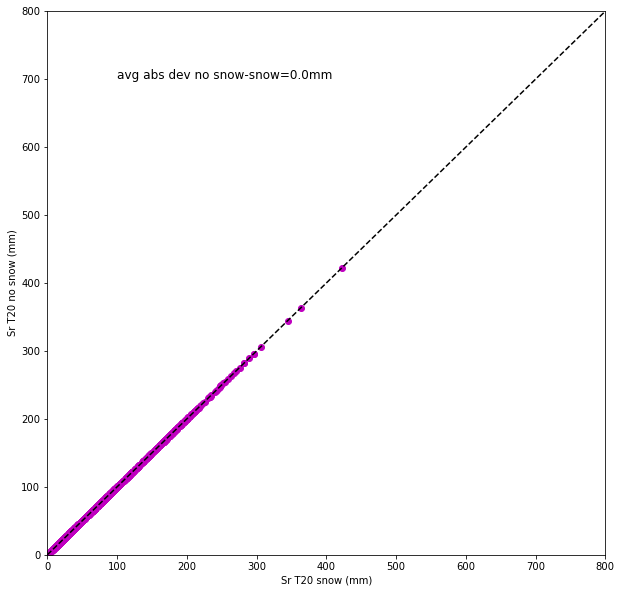

In [92]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(sr_df.sr_20_snow, sr_df.sr_20_nosnow, 'mo')
ax.plot([0,900],[0,900],'k--')
ax.set_xlabel('Sr T20 snow (mm)')
ax.set_ylabel('Sr T20 no snow (mm)')
ax.annotate(f'avg abs dev no snow-snow={np.round(abs(sr_df.sr_20_nosnow-sr_df.sr_20_snow).mean(),0)}mm',[100,700],size=12)
ax.set_xlim(0,800)
ax.set_ylim(0,800)